# **LSTM**

In [ ]:
pip install pandas numpy matplotlib arch

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0495
Epoch 2/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0148
Epoch 3/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0238
Epoch 4/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0175
Epoch 5/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0160
Epoch 6/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0107
Epoch 7/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0055
Epoch 8/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0074
Epoch 9/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0159
Epoch 10/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0059
Epoch 11/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0115
Epoch 12/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0057
Epoch 13/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0065
Epoch 14/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0055
Epoch 15/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0057
Epoch 16/100


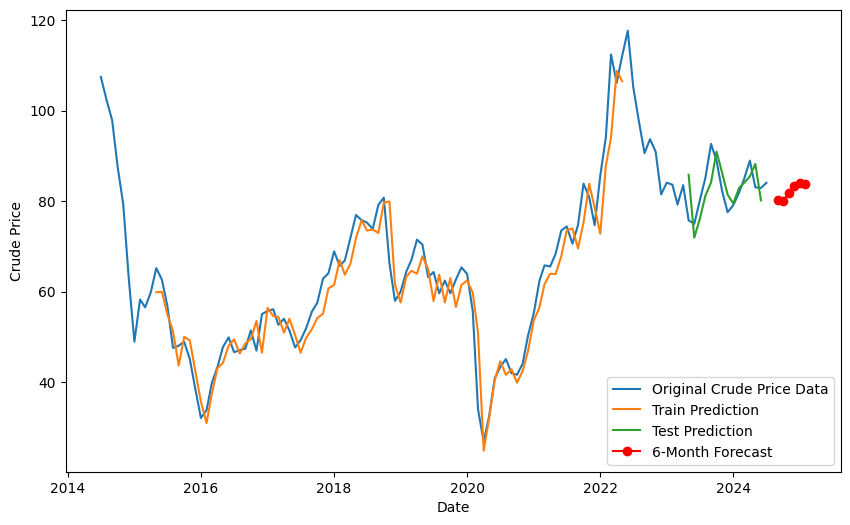

Predicted Samples for the Next 6 Months:
             Forecast
2024-08-31  80.164276
2024-09-30  80.121811
2024-10-31  81.752533
2024-11-30  83.368469
2024-12-31  84.022896
2025-01-31  83.716644


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from matplotlib import pyplot as plt

# Load the dataset
file_path = "/content/Crude_Price_Exogenous_Factors.csv"
df_crude = pd.read_csv(file_path)

# Convert 'Date' to datetime format and set as index
df_crude['Date'] = pd.to_datetime(df_crude['Date'], format='%d/%m/%y')
df_crude.set_index('Date', inplace=True)

# Select the 'Crude_Price' column for prediction
dataset = df_crude['Crude_Price'].values.reshape(-1, 1)

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

# Split the data into training and testing sets (80% training, 20% testing)
train_size = int(len(scaled_data) * 0.8)
train, test = scaled_data[0:train_size, :], scaled_data[train_size:len(scaled_data), :]

# Function to create a dataset for LSTM
def create_dataset(dataset, time_step=1):
    X, Y = [], []
    for i in range(len(dataset) - time_step - 1):
        X.append(dataset[i:(i + time_step), 0])
        Y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(Y)

# Prepare the input data
time_step = 10  # Using a 10-time-step lookback
X_train, y_train = create_dataset(train, time_step)
X_test, y_test = create_dataset(test, time_step)

# Reshape input to be [samples, time steps, features] as required for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Create the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, batch_size=1, epochs=100)

# Predict the train and test data
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform to get the original scale
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
y_train = scaler.inverse_transform([y_train])
y_test = scaler.inverse_transform([y_test])

# Forecasting the next 6 months
last_time_step = X_test[-1]  # Use the last known data from the test set
forecast = []

for _ in range(6):  # Predict the next 6 months
    next_prediction = model.predict(last_time_step.reshape(1, time_step, 1))
    forecast.append(next_prediction[0, 0])

    # Update the last_time_step with the latest prediction
    last_time_step = np.append(last_time_step[1:], next_prediction)

# Inverse transform forecast to original scale
forecast = scaler.inverse_transform(np.array(forecast).reshape(-1, 1))


# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(df_crude.index, dataset, label='Original Crude Price Data')
plt.plot(df_crude.index[time_step:len(train_predict) + time_step], train_predict, label='Train Prediction')
plt.plot(df_crude.index[len(train_predict) + (time_step * 2) + 1:len(dataset) - 1], test_predict, label='Test Prediction')

# Adding forecast data to the plot
forecast_index = pd.date_range(start=df_crude.index[-1], periods=7, freq='M')[1:] # Changed from periods=9 to periods=7
plt.plot(forecast_index, forecast, label='6-Month Forecast', color='red', marker='o')
plt.xlabel('Date')
plt.ylabel('Crude Price')
plt.legend()
plt.show()

# Display predicted samples for the next 6 months
forecast_df = pd.DataFrame(forecast, index=forecast_index, columns=['Forecast'])
print("Predicted Samples for the Next 6 Months:")
print(forecast_df)


In [ ]:
import numpy as np
# Calculate AIC and BIC for the LSTM model
# AIC and BIC are typically used for statistical models like ARIMA.
# For LSTM, these values might not be directly interpretable.
# You can use these values for relative comparison between different LSTM models.

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test[0], test_predict[:, 0]))
print('Test RMSE: %.4f' % (rmse))

# Calculate AIC and BIC
# These are approximations as LSTM doesn't fit the standard AIC/BIC assumptions
n = len(y_test[0])  # Number of observations
k =  model.count_params()  # Number of parameters in the model
sse = np.sum((y_test[0] - test_predict[:, 0]) ** 2)  # Sum of squared errors

# AIC approximation
aic = 2 * k + n * np.log(sse / n)
print('AIC approximation:', aic)

# BIC approximation
bic = n * np.log(sse / n) + k * np.log(n)
print('BIC approximation:', bic)


Test RMSE: 4.6368
AIC approximation: 63844.952678913
BIC approximation: 84231.52055096936


Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


85/85 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0482
Epoch 2/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0223
Epoch 3/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0199
Epoch 4/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0144
Epoch 5/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0115
Epoch 6/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0106
Epoch 7/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0092
Epoch 8/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0100
Epoch 9/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0083
Epoch 10/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0089
Epoch 11/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0095
Epoch 12/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0052
Epoch 13/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0074
Epoch 14/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0061
Epoch 15/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0035
Epoch 16/100
8

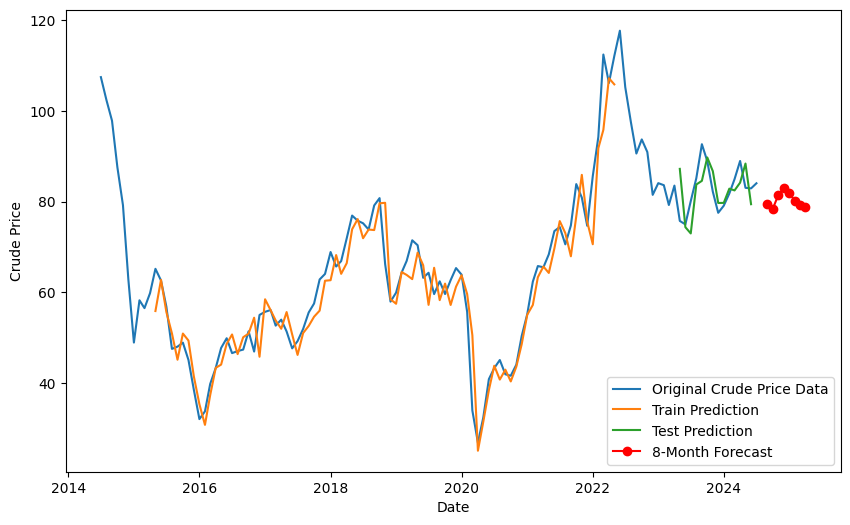

Predicted Samples for the Next 8 Months:
             Forecast
2024-08-31  79.436836
2024-09-30  78.394547
2024-10-31  81.500854
2024-11-30  82.974022
2024-12-31  81.900017
2025-01-31  80.187012
2025-02-28  79.202133
2025-03-31  78.876038


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from matplotlib import pyplot as plt

# Load the dataset
file_path = "/content/Crude_Price_Exogenous_Factors.csv"
df_crude = pd.read_csv(file_path)

# Convert 'Date' to datetime format and set as index
df_crude['Date'] = pd.to_datetime(df_crude['Date'], format='%d/%m/%y')
df_crude.set_index('Date', inplace=True)

# Select the 'Crude_Price' column for prediction
dataset = df_crude['Crude_Price'].values.reshape(-1, 1)

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

# Split the data into training and testing sets (80% training, 20% testing)
train_size = int(len(scaled_data) * 0.8)
train, test = scaled_data[0:train_size, :], scaled_data[train_size:len(scaled_data), :]

# Function to create a dataset for LSTM
def create_dataset(dataset, time_step=1):
    X, Y = [], []
    for i in range(len(dataset) - time_step - 1):
        X.append(dataset[i:(i + time_step), 0])
        Y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(Y)

# Prepare the input data
time_step = 10  # Using a 10-time-step lookback
X_train, y_train = create_dataset(train, time_step)
X_test, y_test = create_dataset(test, time_step)

# Reshape input to be [samples, time steps, features] as required for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Create the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, batch_size=1, epochs=100)

# Predict the train and test data
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform to get the original scale
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
y_train = scaler.inverse_transform([y_train])
y_test = scaler.inverse_transform([y_test])

# Forecasting the next 8 months
last_time_step = X_test[-1]  # Use the last known data from the test set
forecast = []

for _ in range(8):  # Predict the next 8 months
    next_prediction = model.predict(last_time_step.reshape(1, time_step, 1))
    forecast.append(next_prediction[0, 0])

    # Update the last_time_step with the latest prediction
    last_time_step = np.append(last_time_step[1:], next_prediction)

# Inverse transform forecast to original scale
forecast = scaler.inverse_transform(np.array(forecast).reshape(-1, 1))

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(df_crude.index, dataset, label='Original Crude Price Data')
plt.plot(df_crude.index[time_step:len(train_predict) + time_step], train_predict, label='Train Prediction')
plt.plot(df_crude.index[len(train_predict) + (time_step * 2) + 1:len(dataset) - 1], test_predict, label='Test Prediction')

# Adding forecast data to the plot
forecast_index = pd.date_range(start=df_crude.index[-1], periods=9, freq='M')[1:]
plt.plot(forecast_index, forecast, label='8-Month Forecast', color='red', marker='o')
plt.xlabel('Date')
plt.ylabel('Crude Price')
plt.legend()
plt.show()

# Display predicted samples for the next 8 months
forecast_df = pd.DataFrame(forecast, index=forecast_index, columns=['Forecast'])
print("Predicted Samples for the Next 8 Months:")
print(forecast_df)


In [ ]:
import numpy as np
# Calculate AIC and BIC for the LSTM model
# AIC and BIC are typically used for statistical models like ARIMA.
# For LSTM, these values might not be directly interpretable.
# You can use these values for relative comparison between different LSTM models.

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test[0], test_predict[:, 0]))
print('Test RMSE: %.4f' % (rmse))

# Calculate AIC and BIC
# These are approximations as LSTM doesn't fit the standard AIC/BIC assumptions
n = len(y_test[0])  # Number of observations
k =  model.count_params()  # Number of parameters in the model
sse = np.sum((y_test[0] - test_predict[:, 0]) ** 2)  # Sum of squared errors

# AIC approximation
aic = 2 * k + n * np.log(sse / n)
print('AIC approximation:', aic)

# BIC approximation
bic = n * np.log(sse / n) + k * np.log(n)
print('BIC approximation:', bic)


Test RMSE: 5.3605
AIC approximation: 63849.013736338675
BIC approximation: 84235.58160839503


# **ARCH and Garch**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model

# Load the dataset (adjust the path as needed)
data = pd.read_csv('/content/Crude_Price_Exogenous_Factors.csv')

# Strip any leading/trailing spaces from the 'Period' column
data['Date'] = data['Date'].str.strip() # Remove potential leading/trailing spaces

# Convert 'Date column' to a Date format
# Convert 'Date column' to a Date format
data['Date'] = pd.to_datetime(data['Date'], format='%d/%m/%y')

# Remove NA values
data = data.dropna()

# Set 'Period' as the index
data.set_index('Date', inplace=True)


# Extract the 'Crude_Price' column
Crude_Price = data['Crude_Price']

# Fit ARCH and GARCH models
# Fit a basic ARCH model
arch_model_basic = arch_model(Crude_Price, vol='ARCH', p=1)
arch_result = arch_model_basic.fit()
print("ARCH Model Results:")
print(arch_result.summary())

# Fit a GARCH(1, 1) model
garch_model = arch_model(Crude_Price, vol='Garch', p=1, q=1)
garch_result = garch_model.fit()
print("GARCH(1, 1) Model Results:")
print(garch_result.summary())

# Forecasting Volatility for 8 months (8 * 30 days)
forecast_horizon = 240
forecast = garch_result.forecast(horizon=forecast_horizon)

# Extract forecasted volatility
volatility_forecast = forecast.variance.iloc[-1].values

# Plot the forecasted volatility
#plt.figure(figsize=(10, 6))
#plt.plot(volatility_forecast, color='blue')
#plt.title('8-Month Forecasted Volatility for \'Issues\'')
#plt.xlabel('Days')
#plt.ylabel('Forecasted Volatility')
#plt.grid(True)
#plt.show()

Iteration:      1,   Func. Count:      5,   Neg. LLF: 495.45384439337175
Iteration:      2,   Func. Count:      9,   Neg. LLF: 625.7901093316613
Iteration:      3,   Func. Count:     14,   Neg. LLF: 494.3260181043549
Iteration:      4,   Func. Count:     18,   Neg. LLF: 494.31449180746546
Iteration:      5,   Func. Count:     22,   Neg. LLF: 494.30968699192033
Iteration:      6,   Func. Count:     26,   Neg. LLF: 494.285111399525
Iteration:      7,   Func. Count:     30,   Neg. LLF: 494.239400576336
Iteration:      8,   Func. Count:     34,   Neg. LLF: 494.14990841711165
Iteration:      9,   Func. Count:     38,   Neg. LLF: 494.0737943515471
Iteration:     10,   Func. Count:     42,   Neg. LLF: 494.04432307304734
Iteration:     11,   Func. Count:     46,   Neg. LLF: 494.0399957178483
Iteration:     12,   Func. Count:     50,   Neg. LLF: 494.0399683980116
Iteration:     13,   Func. Count:     53,   Neg. LLF: 494.0399684045027
Optimization terminated successfully    (Exit mode 0)
       

In [ ]:
import numpy as np
# Get the fitted values from the ARCH model
fitted_values_arch = arch_result.conditional_volatility

# Calculate RMSE for the ARCH model
rmse_arch = np.sqrt(mean_squared_error(Crude_Price, fitted_values_arch))
print("RMSE of ARCH model:", rmse_arch)

RMSE of ARCH model: 53.06791067222541


In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error

# Get the fitted values from the GARCH model
fitted_values = garch_result.conditional_volatility

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(Crude_Price, fitted_values))
print("RMSE of GARCH model:", rmse)

RMSE of GARCH model: 53.29970319479778
